<h1 align="center"> Image Captioning (8 points) </h1>

In this notebook you will teach a network to do image captioning
![img](https://i.imgur.com/obITaMl.png)



#### Alright, here's our plan:
1. Take a pre-trained inception v3 to vectorize images
2. Stack an LSTM on top of it
3. Train the thing on [MSCOCO](http://cocodataset.org/#download)

In [1]:
# Please either download data from https://yadi.sk/d/b4nAwIE73TVcp5 or generate it manually with preprocess_data.ipynb

### Data preprocessing

In [2]:
# %%time
# Read Dataset
import numpy as np
import json

img_codes = np.load("data/image_codes.npy")
captions = json.load(open('data/captions_tokenized.json'))

### Data structure

To save your time, we've already vectorized all MSCOCO17 images with a pre-trained inception_v3 network from [torchvision](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py).

The whole process takes anywhere between a day on CPU and 10min on 3x tesla m40. If you want to play with that yourself, [you're welcome](https://gist.github.com/justheuristic/11fd01f9c12c0bf960499580d104130b).

In [3]:
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


As you can see, all captions are already tokenized and lowercased. We now want to split them and add some special tokens for start/end of caption.

In [4]:
#split descriptions into tokens
for img_i in range(len(captions)):
    for caption_i in range(len(captions[img_i])):
        sentence = captions[img_i][caption_i] 
        captions[img_i][caption_i] = ["#START#"]+sentence.split(' ')+["#END#"]


You don't want your network to predict a million-size vector of probabilities at each step, so we're gotta make some cuts. 

We want you to __count the occurences of each word__ so that we can decide which words to keep in our vocabulary.

In [5]:
# Build a Vocabulary
from collections import Counter
word_counts = Counter()

# Compute word frequencies for each word in captions. See code above for data structure
# <YOUR CODE HERE>
for five_captions in captions:
    for caption in five_captions:
        word_counts.update(caption)

In [6]:
vocab  = ['#UNK#', '#START#', '#END#', '#PAD#']
vocab += [k for k, v in word_counts.items() if v >= 5 if k not in vocab]
n_tokens = len(vocab)

assert 10000 <= n_tokens <= 10500

word_to_index = {w: i for i, w in enumerate(vocab)}

In [7]:
eos_ix = word_to_index['#END#']
unk_ix = word_to_index['#UNK#']
pad_ix = word_to_index['#PAD#']

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    max_len = max_len or max(map(len,sequences))
    
    matrix = np.zeros((len(sequences), max_len), dtype='int32') + pad_ix
    for i,seq in enumerate(sequences):
        row_ix = [word_to_index.get(word, unk_ix) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [8]:
#try it out on several descriptions of a random image
as_matrix(captions[1337])

array([[   1,   24,  262,  140,    6,  159,   14,   24,  858,  155,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  155,    2,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   41,   18,  903,   35,  620,  155,    2,    3,
           3,    3,    3,    3,    3,    3,    3,    3],
       [   1,   45,  115,  262,   41,   53,   18,  620, 1525,   77,   12,
           2,    3,    3,    3,    3,    3,    3,    3],
       [   1,   24,  262,   53,   18,   24,  858,  123,   58,   45,  276,
        3641,   24, 3642,   35,   45, 1128,   12,    2]], dtype=int32)

### Building our neural network

As we mentioned earlier, we shall build an rnn "language-model" conditioned on vectors from the convolutional part. 

![img](https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png)
_image: http://bit.ly/2FKnqHm_


We'll unbox the inception net later to save memory, for now just pretend that it's available.


In [9]:
import torch, torch.nn as nn
import torch.nn.functional as F

In [10]:
class CaptionNet(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=128, lstm_units=256, cnn_feature_size=2048):
        """ A recurrent 'head' network for image captioning. See scheme above. """
        super(self.__class__, self).__init__()
        
        # a layer that converts conv features to 
        self.cnn_to_h0 = nn.Linear(cnn_feature_size, lstm_units)
        self.cnn_to_c0 = nn.Linear(cnn_feature_size, lstm_units)
        
        # recurrent part, please create the layers as per scheme above.

        # create embedding for input words. Use the parameters (e.g. emb_size).
        self.emb = nn.Embedding(n_tokens, emb_size) # <YOUR CODE> 
            
        # lstm: create a recurrent core of your network. Use either LSTMCell or just LSTM. 
        # In the latter case (nn.LSTM), make sure batch_first=True
        self.lstm = nn.LSTM(emb_size, lstm_units, batch_first=True) # <YOUR CODE>
            
        # create logits: linear layer that takes lstm hidden state as input and computes one number per token
        self.logits = nn.Linear(lstm_units, n_tokens) # <YOUR CODE> 
        
    def forward(self, image_vectors, captions_ix):
        """ 
        Apply the network in training mode. 
        :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
        :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
            padded with pad_ix
        :returns: logits for next token at each tick, shape: [batch, word_i, n_tokens]
        """
        initial_cell = self.cnn_to_c0(image_vectors)
        initial_hid = self.cnn_to_h0(image_vectors)
        
        # compute embeddings for captions_ix
        captions_emb = self.emb(captions_ix) # <YOUR CODE>
        
        # apply recurrent layer to captions_emb. 
        # 1. initialize lstm state with initial_* from above
        # 2. feed it with captions. Mind the dimension order in docstring
        # 3. compute logits for next token probabilities
        # Note: if you used nn.LSTM, you can just give it (initial_cell[None], initial_hid[None]) as second arg
        
        out, _ = self.lstm(captions_emb, (initial_hid[None], initial_cell[None]))
            
        # lstm_out should be lstm hidden state sequence of shape [batch, caption_length, lstm_units]
        lstm_out = out # <YOUR_CODE>
        
        # compute logits from lstm_out
        logits = self.logits(lstm_out) # <YOUR_CODE>
        
        return logits        

In [11]:
network = CaptionNet(n_tokens).cuda()

In [12]:
dummy_img_vec = torch.randn(len(captions[0]), 2048)
dummy_capt_ix = torch.tensor(as_matrix(captions[0]), dtype=torch.int64)

dummy_logits = network.forward(dummy_img_vec.cuda(), dummy_capt_ix.cuda())

print('shape:', dummy_logits.shape)
assert dummy_logits.shape == (dummy_capt_ix.shape[0], dummy_capt_ix.shape[1], n_tokens)

shape: torch.Size([5, 16, 10403])


In [13]:
def compute_loss(network, image_vectors, captions_ix):
    """
    :param image_vectors: torch tensor containing inception vectors. shape: [batch, cnn_feature_size]
    :param captions_ix: torch tensor containing captions as matrix. shape: [batch, word_i]. 
        padded with pad_ix
    :returns: scalar crossentropy loss (neg llh) loss for next captions_ix given previous ones
    """
    
    # captions for input - all except last cuz we don't know next token for last one.
    captions_ix_inp = captions_ix[:, :-1].contiguous().cuda()
    captions_ix_next = captions_ix[:, 1:].contiguous().cuda()
    
    # apply the network, get predictions for captions_ix_next
    logits_for_next = network.forward(image_vectors.cuda(), captions_ix_inp)
    
    
    # compute the loss function between logits_for_next and captions_ix_next
    # Use the mask, Luke: make sure that predicting next tokens after EOS do not contribute to loss
    # you can do that either by multiplying elementwise loss by (captions_ix_next != pad_ix)
    # or by using ignore_index in some losses.
    
    loss = torch.nn.functional.cross_entropy(logits_for_next.permute((0,2,1)), 
                                             captions_ix_next, ignore_index=pad_ix)[None] # <YOUR CODE>
    
    return loss

In [14]:
dummy_loss = compute_loss(network, dummy_img_vec, dummy_capt_ix)

assert dummy_loss.shape == torch.Size([1]), 'loss must be scalar'
assert dummy_loss.data.cpu().numpy() > 0, "did you forget the 'negative' part of negative log-likelihood"

dummy_loss.backward()

assert all(param.grad is not None for param in network.parameters()), \
        'loss should depend differentiably on all neural network weights'

Create ~~adam~~ your favorite optimizer for the network.

In [15]:
# <YOUR CODE>
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)

# Training

* First implement the batch generator
* Than train the network as usual

In [16]:
from sklearn.model_selection import train_test_split
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

In [17]:
from random import choice

def generate_batch(img_codes, captions, batch_size, max_caption_len=None):
    
    #sample random numbers for image/caption indicies
    random_image_ix = np.random.randint(0, len(img_codes), size=batch_size)
    
    #get images
    batch_images = img_codes[random_image_ix]
    
    #5-7 captions for each image
    captions_for_batch_images = captions[random_image_ix]
    
    #pick one from a set of captions for each image
    batch_captions = list(map(choice,captions_for_batch_images))
    
    #convert to matrix
    batch_captions_ix = as_matrix(batch_captions,max_len=max_caption_len)
    
    return torch.tensor(batch_images, dtype=torch.float32), torch.tensor(batch_captions_ix, dtype=torch.int64)
    

In [18]:
generate_batch(img_codes,captions,3)

(tensor([[0.4726, 0.0712, 0.1663,  ..., 0.3029, 0.6585, 0.3210],
         [0.1767, 0.4335, 0.4292,  ..., 0.0487, 1.1128, 0.5308],
         [0.3072, 0.0249, 0.4422,  ..., 0.4653, 0.1745, 0.1230]]),
 tensor([[   1,   88, 1534,   17,   94,   35,   45,  307,  123,   15,  380, 1462,
           440,  666, 6654,  117, 2452, 2448,   15,    0, 6496,   12,    2],
         [   1,   45,  541,  542, 1142,  620,  543,    6, 2572,    2,    3,    3,
             3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3],
         [   1,   24,   54, 4157,  876,   41,  552,   31,   45,   97,   58, 9535,
          3930,   12,    2,    3,    3,    3,    3,    3,    3,    3,    3]]))

### Main loop

Train on minibatches just as usual. Evaluate on val from time to time.

##### TIps
* If training loss has become close to 0 or model produces garbage,
    double-check that you're predicting __next__ words, not current or t+2'th words.
* If the model generates fluent captions that have nothing to do with the images
 * this may be due to recurrent net not receiving image vectors.
 * alternatively it may be caused by gradient explosion, try clipping 'em or just restarting the training
 * finally, you may just need to train the model a bit more


* Crossentropy is a poor measure of overfitting
 * Model can overfit validation crossentropy but keep improving validation quality.
 * Use human _(manual)_ evaluation or try automated metrics: [cider](https://github.com/vrama91/cider) or [bleu](https://www.nltk.org/_modules/nltk/translate/bleu_score.html)
 

* We recommend you to periodically evaluate the network using the next "apply trained model" block
 *  its safe to interrupt training, run a few examples and start training again
 
* The typical loss values should be around 3~5 if you average over time, scale by length if you sum over time. The reasonable captions began appearing at loss=2.8 ~ 3.0
 

In [19]:
batch_size = 300 #50  # adjust me
n_epochs = 100 # adjust me
n_batches_per_epoch = 50  # adjust me
n_validation_batches = 5  # how many batches are used for validation after each epoch

In [26]:
from tqdm import tqdm

for epoch in range(n_epochs):
    
    train_loss=0
    network.train(True)
    for _ in tqdm(range(n_batches_per_epoch)):
        
        loss_t = compute_loss(network, *generate_batch(train_img_codes, train_captions, batch_size))
        
        
        # clear old gradients; do a backward pass to get new gradients; then train with opt
        # <YOUR CODE>
        optimizer.zero_grad()
        loss_t.backward()
        optimizer.step()
        
        train_loss += loss_t.item()
        
    train_loss /= n_batches_per_epoch
    
    val_loss=0
    network.train(False)
    for _ in range(n_validation_batches):
        loss_t = compute_loss(network, *generate_batch(val_img_codes, val_captions, batch_size))
        val_loss += loss_t.item()
    val_loss /= n_validation_batches
    
    print('\nEpoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

print("Finished!")

  2%|▏         | 1/50 [00:00<00:08,  5.70it/s]


Epoch: 0, train loss: 2.375972270965576, val loss: 2.4897823333740234


  2%|▏         | 1/50 [00:00<00:06,  7.73it/s]


Epoch: 1, train loss: 2.383616361618042, val loss: 2.461404800415039


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 2, train loss: 2.374268217086792, val loss: 2.4706106185913086


  2%|▏         | 1/50 [00:00<00:09,  5.20it/s]


Epoch: 3, train loss: 2.3716479969024657, val loss: 2.4762560367584228


  0%|          | 0/50 [00:00<?, ?it/s]


Epoch: 4, train loss: 2.3894592237472536, val loss: 2.428343486785889


  2%|▏         | 1/50 [00:00<00:07,  6.98it/s]


Epoch: 5, train loss: 2.3718089389801027, val loss: 2.4442118644714355


  2%|▏         | 1/50 [00:00<00:04,  9.82it/s]


Epoch: 6, train loss: 2.3732125186920165, val loss: 2.4687219619750977


 66%|██████▌   | 33/50 [00:04<00:01,  8.73it/s]


KeyboardInterrupt: 

In [25]:
# for g in optimizer.param_groups:
#     g['lr'] *= .1

### Apply trained model

Let's unpack our pre-trained inception network and see what our model is capable of.

In [27]:
from beheaded_inception3 import beheaded_inception_v3
inception = beheaded_inception_v3().train(False)

### Generate caption

The function below creates captions by sampling from probabilities defined by the net.

The implementation used here is simple but inefficient (quadratic in lstm steps). We keep it that way since it isn't a performance bottleneck.

In [28]:
def generate_caption(image, caption_prefix=("#START#",), 
                     t=1, sample=True, max_len=100):
    assert isinstance(image, np.ndarray) and np.max(image) <= 1\
           and np.min(image) >=0 and image.shape[-1] == 3
    
    with torch.no_grad():
        image = torch.tensor(image.transpose([2, 0, 1]), dtype=torch.float32)

        vectors_8x8, vectors_neck, logits = inception(image[None])
        caption_prefix = list(caption_prefix)

        for _ in range(max_len):

            prefix_ix = as_matrix([caption_prefix])
            prefix_ix = torch.tensor(prefix_ix, dtype=torch.int64)
            next_word_logits = network.forward(vectors_neck.cuda(), prefix_ix.cuda())[0, -1]
            next_word_probs = F.softmax(next_word_logits, dim=-1).data.cpu().numpy()

            assert len(next_word_probs.shape) ==1, 'probs must be one-dimensional'
            next_word_probs = next_word_probs ** t / np.sum(next_word_probs ** t) # apply temperature

            if sample:
                next_word = np.random.choice(vocab, p=next_word_probs) 
            else:
                next_word = vocab[np.argmax(next_word_probs)]

            caption_prefix.append(next_word)

            if next_word == "#END#":
                break
            
    return caption_prefix

--2019-05-05 19:50:04--  https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg
Resolving pixel.nymag.com (pixel.nymag.com)... 151.101.244.70
Connecting to pixel.nymag.com (pixel.nymag.com)|151.101.244.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107928 (105K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 105,40K   535KB/s    in 0,2s    

2019-05-05 19:50:04 (535 KB/s) - ‘data/img.jpg’ saved [107928/107928]



/home/viktor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


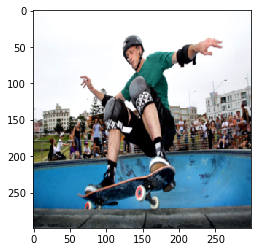

a man riding a skateboard down a ramp .
a man riding a skateboard on a ramp .
a man riding a skateboard on top of a ramp .
a man is doing a trick on a skateboard .
a man doing a trick on a skateboard .
a man on a skateboard doing a trick on a skateboard .
a man on a skateboard doing a trick .
a man is doing a trick on a skateboard .
a man riding a skateboard on a ramp .
a man riding a skateboard down a ramp .


In [33]:
from matplotlib import pyplot as plt
from scipy.misc import imresize
%matplotlib inline

#sample image
!wget https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

--2019-05-05 19:50:11--  http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg
Resolving ccanimalclinic.com (ccanimalclinic.com)... 23.185.0.2, 2620:12a:8000::2, 2620:12a:8001::2
Connecting to ccanimalclinic.com (ccanimalclinic.com)|23.185.0.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106870 (104K) [image/jpeg]
Saving to: ‘data/img.jpg’

data/img.jpg        100%[===================>] 104,37K  --.-KB/s    in 0,06s   

2019-05-05 19:50:11 (1,63 MB/s) - ‘data/img.jpg’ saved [106870/106870]



/home/viktor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


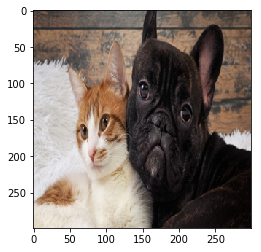

a brown and white cat laying on a bed .
a white and black cat is laying on a bed .
a brown and white cat laying on a bed .
a white and black cat laying on a bed .
a white and black cat laying on top of a white blanket .
a brown and white cat is laying on a couch .
a close up of a cat on a leash
a cat is laying on the floor next to a car .
a cat is laying on the floor next to a car .
a brown and white cat laying on top of a bed .


In [34]:
!wget http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg -O data/img.jpg
img = plt.imread('data/img.jpg')
img = imresize(img, (299, 299)).astype('float32') / 255.

plt.imshow(img)
plt.show()

for i in range(10):
    print(' '.join(generate_caption(img, t=5.)[1:-1]))

# Demo
### Find at least 10 images to test it on.

* Seriously, that's a part of the assignment. Go get at least 10 pictures for captioning
* Make sure it works okay on __simple__ images before going to something more complex
* Your pictures must feature both successful and failed captioning. Get creative :)
* Use photos, not animation/3d/drawings, unless you want to re-train CNN network on anime
* Mind the aspect ratio.

In [ ]:
# apply your network on images you've found
#
#

Good hunting!
![img](https://cs7.pikabu.ru/images/big_size_comm_an/2018-09_3/1536865148163644198.gif)

In [100]:
# !wget https://i.pinimg.com/originals/f3/87/d4/f387d41f1afefa4eb85835bb48b1d030.jpg -O data/0.jpg
# !wget https://akns-images.eonline.com/eol_images/Entire_Site/2019221/rs_600x600-190321191448-https__hypebegggast.com_image_2019_03_avengers-endgame-trailer-fake-footage-1.jpg -O data/1.jpg
!wget https://images.fineartamerica.com/images-medium-large-5/people-walking-on-city-street-sven-hartmann--eyeem.jpg -O data/2.jpg
# !wget https://i1.sndcdn.com/artworks-000120795662-2s9iuk-t500x500.jpg -O data/3.jpg
# !wget https://inhsultimate.files.wordpress.com/2014/02/jesse-square.jpg -O data/4.jpg
# !wget https://www.zigzagtravel.com.ar/entity/zigzag/images/Product/126/large/sq_cabalgata_bariloche_-_estepa2.jpg -O data/5.jpg
# !wget https://media1.popsugar-assets.com/files/thumbor/jXdXfcX6aLoRz_arfua0RDvizbs/fit-in/2048xorig/filters:format_auto-!!-:strip_icc-!!-/2017/08/07/843/n/1922283/248b865f5988bc43f2e507.80115777_edit_img_image_15775818_1502133104/i/Reactions-Dothraki-Battle-Game-Thrones.jpg -O data/6.jpg
# !wget https://media.ussportscamps.com/media/images/soccer/northwest/_400x400_crop_top-center_75_none/nw_feature_thumbnail2_400x400.jpg -O data/7.jpg
# !wget https://2o6xc029qclz1ztcv91aw7lr-wpengine.netdna-ssl.com/wp-content/uploads/2011/01/Airplane-Accident-Attorneys.jpg -O data/8.jpg
# !wget https://pbs.twimg.com/profile_images/3085690201/04f340e1065c1ec76b0fd3f4f8fd36df_400x400.jpeg -O data/9.jpg
# !wget https://media1.popsugar-assets.com/files/thumbor/iIJ68KGGaeoHX4GawrwFOw3LYz0/fit-in/2048xorig/filters:format_auto-!!-:strip_icc-!!-/2019/01/30/733/n/44344577/c97620945c51d2a6da5ec8.13047229_/i/Videos-Cat-Dog-Who-Snuggle-Together-Every-Day.jpg -O data/10.jpg
# !wget https://i.pinimg.com/originals/5c/c2/b2/5cc2b21e1734c0a7016c5efaeeeae977.jpg -O data/11.jpg
# !wget https://yt3.ggpht.com/a-/AAuE7mCCYpDNvFRu01db_i9izMSeXHaK5q_YR0vntA=s900-mo-c-c0xffffffff-rj-k-no -O data/12.jpg
# !wget https://img.grouponcdn.com/deal/4BrKcnsfjjFJVqyZomtX5TomXvqF/4B-700x420/v1/sc600x600.jpg -O data/13.jpg
# !wget https://i.pinimg.com/originals/c6/12/5a/c6125a952249a420a50f82160834b402.jpg -O data/14.jpg
# !wget https://images.wallpaperscraft.com/image/biker_motorcycle_extreme_122250_2780x2780.jpg -O data/15.jpg
# !wget https://i.pinimg.com/originals/ba/e2/e9/bae2e9206ce65fbe1212fd74cbbd9dff.jpg -O data/16.jpg
# !wget https://ozonekites.net/prodimages/giant/ozone_hyperlink_v1_size_color-3.jpg -O data/17.jpg
# !wget https://lonelyplanetwpnews.imgix.net/2018/03/unicorn-pool-float.jpeg -O data/18.jpg
# !wget https://farm3.static.flickr.com/2796/4465471504_a4f148bb04_b.jpg -O data/19.jpg
# !wget https://images.fineartamerica.com/images-medium-large-5/people-walking-on-city-street-sven-hartmann--eyeem.jpg -O data/20.jpg

--2019-05-05 22:46:45--  https://images.fineartamerica.com/images-medium-large-5/people-walking-on-city-street-sven-hartmann--eyeem.jpg
Resolving images.fineartamerica.com (images.fineartamerica.com)... 13.32.56.91, 13.32.56.17, 13.32.56.77, ...
Connecting to images.fineartamerica.com (images.fineartamerica.com)|13.32.56.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 342008 (334K) [image/jpeg]
Saving to: ‘data/2.jpg’

data/2.jpg          100%[===================>] 333,99K  --.-KB/s    in 0,08s   

2019-05-05 22:46:45 (4,26 MB/s) - ‘data/2.jpg’ saved [342008/342008]



/home/viktor/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  This is separate from the ipykernel package so we can avoid doing imports until


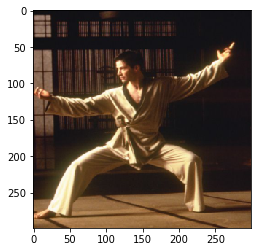

a man on a skateboard in the air .
a man in a suit and tie is sitting on a bench .
a man in a suit and tie is sitting on a bench .
a man in a suit and tie is sitting on a bench .
a man on a skateboard is in the air .
a man in a suit and tie sitting on a bench .
a man on a skateboard in the middle of a park .
a man in a suit and tie sitting on a bench .
a man in a suit and tie is sitting on a bench .
a man sitting on a bench with a skateboard .


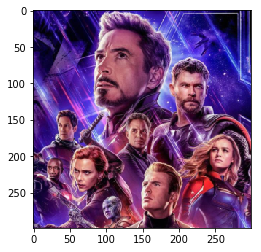

a woman and a woman are standing next to a man .
a group of people standing around a group of people .
a woman and a woman are standing next to a man .
a woman and a woman standing next to a woman .
a woman and a girl are standing next to a man .
a woman holding a teddy bear in her hand .
a group of people that are standing together .
a woman and a woman are standing together in a parade .
a woman and a woman are standing next to a woman .
a woman and a woman are standing next to a man .


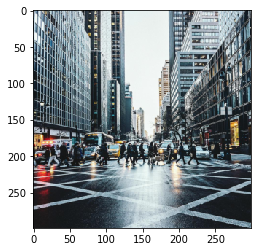

a busy city street with people walking and buildings .
a busy city street with cars and buildings .
a busy city street with a lot of traffic .
a busy city street with a lot of people walking down the street .
a busy city street with people walking and buildings .
a busy city street with a lot of people walking in the rain .
a busy city street with people walking and a street sign .
a busy city street with people walking and cars
a city street with cars and buildings in the background .
a busy city street with people walking and cars


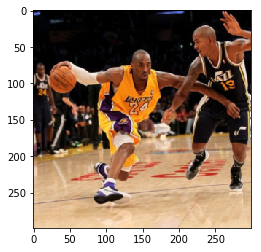

a group of people playing a game of frisbee .
a group of people playing a game of frisbee .
a group of people playing a game of soccer .
a group of people playing a game of frisbee .
a group of people playing a game of soccer .
a group of people playing a game of soccer .
a group of people playing a game of frisbee .
a group of people playing a game of soccer .
a group of people playing a game of frisbee .
a group of people playing a game of tennis .


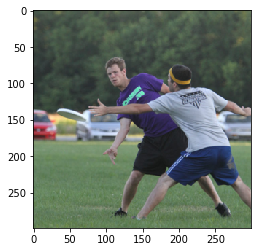

a man in a field with a frisbee in his mouth .
a man in a field playing a game of frisbee .
a man in a white shirt playing with a frisbee .
a man in a white shirt and a white frisbee .
a man in a red shirt is playing frisbee .
a man is holding a frisbee in his mouth .
a man in a red shirt is playing frisbee .
a man in a field with a frisbee in his mouth .
a man in a field with a frisbee in his mouth .
a man in a white shirt and a white frisbee .


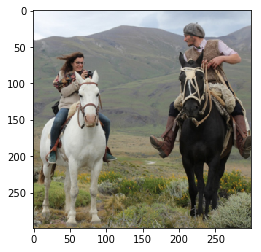

a group of people riding horses on a track .
a group of people riding horses on a dirt road .
a group of people riding horses on a track .
a group of people riding horses on a track .
a group of people riding horses on a track .
a group of people riding horses on a field .
a group of people riding horses on a track .
a group of people riding horses on a track .
a woman riding a horse on a track .
a group of people riding horses on a track .


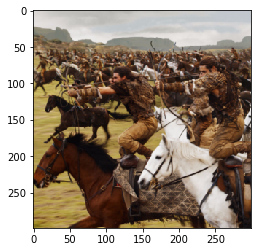

a group of cows that are standing in the grass .
a herd of cows standing on top of a dirt road .
a group of horses that are in the grass .
a group of people riding horses down a dirt road .
a herd of cattle standing on top of a lush green field .
a herd of cows standing on a dirt road .
a herd of cattle standing on top of a dirt road .
a group of cows are standing in a field .
a group of people riding horses down a dirt road .
a herd of cows standing on a dirt road .


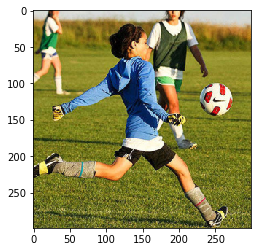

a young boy is kicking a soccer ball on the field .
a soccer player is kicking the ball in the field .
a soccer player is kicking the ball in the field .
a soccer player is kicking the ball in the field .
a young boy is kicking a soccer ball on the field .
a soccer player is kicking the ball in the field .
a soccer player is kicking the ball in the field .
a soccer player is kicking the ball in the field .
a young boy kicking a soccer ball on a field .
a soccer player is kicking the ball in the field .


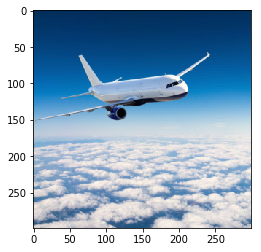

a large jetliner flying through the air with a sky background
a large jetliner flying through the air on a cloudy day .
a large airplane flying in the sky on a cloudy day .
a large jetliner flying through the air on a cloudy day .
a large jetliner flying through the air with a sky background
a large plane is flying in the sky .
a large jetliner flying through the air on a cloudy day .
a large jetliner flying through the air on a cloudy day .
a large jetliner flying through a blue sky .
a large jetliner flying through the air in a cloudy sky .


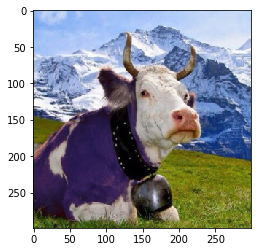

a cow standing in front of a large white cow .
a cow standing in a field with a baby sheep .
a cow standing in a field with a large white cow .
a cow standing in the grass with a cow in its mouth .
a cow with a tag on its head .
a cow standing in the grass with a cow in its mouth .
a cow standing in a field with a cow .
a cow with a hat on its head in a pen .
a cow standing in a field with a sheep .
a cow is standing in the grass with a cow .


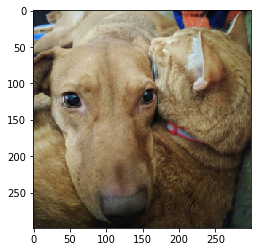

a dog is laying on the floor next to a cat .
a dog is looking at a dog in a car .
a dog is laying on the floor with a cat .
a dog is laying in a white bed .
a dog is looking at a dog in a car .
a dog is lying on a couch with a cat .
a dog is laying on a bed with a cat .
a dog is sitting in a chair with a dog in its mouth .
a dog is laying down on a bed .
a dog is laying on a couch with a cat .


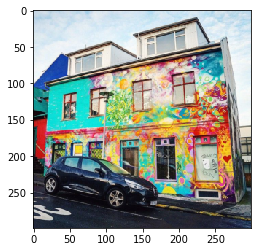

a car parked in front of a building with a clock on it .
a car parked in front of a building .
a car parked in front of a building with a clock .
a car parked in front of a building with a clock .
a car parked in front of a building with a clock .
a car parked in front of a building with a clock on it .
a car parked in front of a building with a clock on it .
a car parked in front of a building with a clock on it .
a car parked in front of a building with a clock on it .
a car parked in front of a building with a clock on it .


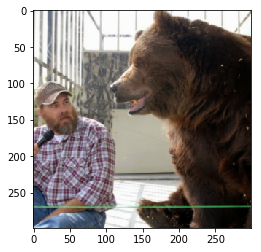

a large brown bear standing next to a fence .
a brown bear sitting on top of a wooden bench .
a large brown bear sitting on a rock next to a fence .
a large brown bear standing next to a fence .
a brown bear is standing next to a large rock .
a brown bear standing next to a rock wall .
a brown bear is sitting on a rock looking at something .
a brown bear sitting on a rock looking at the camera .
a brown bear standing next to a small elephant .
a bear is standing next to a large rock .


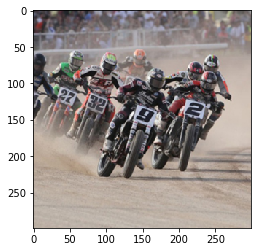

a group of motorcyclists are parked on the street .
a group of people riding motorcycles on a street .
a group of people riding motorcycles down a street .
a group of motorcycles parked on a street .
a group of people riding motorcycles on a street .
a group of people riding motorcycles down a street .
a group of people riding motorcycles down a street .
a group of people riding motorcycles down a road .
a group of people riding motorcycles down a street .
a group of motorcyclists that are parked on the street .


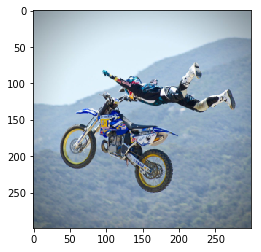

a man riding a motorcycle on a road .
a man riding a motorcycle on a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle on a dirt road .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle on a dirt road .


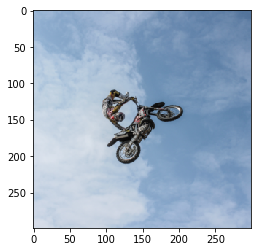

a man on a motorcycle is riding a big ramp .
a man riding a motorcycle on a lush green field .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a street .
a man riding a motorcycle down a hill .
a man riding a motorcycle down a street .
a man riding a skateboard down a ramp .
a man is riding a motorcycle down a hill .
a man riding a motorcycle down a street .


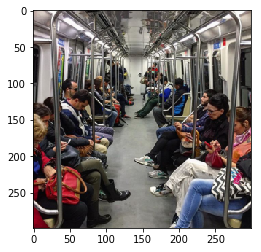

a group of people sitting on a bench in a city .
a group of people sitting on a bench in a city .
a group of people sitting on a bench in a city .
a group of people sitting on a bench on a train .
a group of people sitting on a bench in a city .
a group of people sitting on a bench in a city .
a group of people sitting on a bench in a city .
a group of people sitting on a bench in a city .
a group of people sitting on a bench in a city .
a group of people sitting on a bench in a city .


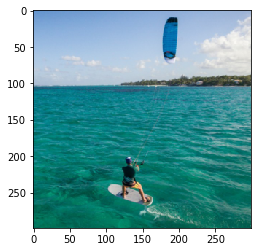

a man is flying a kite in the air .
a man is flying a kite in the ocean .
a man is flying a kite on the beach .
a man is flying a kite on a beach .
a man is flying a kite in the ocean .
a man is flying a kite on a beach .
a man riding a wave on a surfboard in the ocean .
a man on a surfboard in the water .
a man is flying a kite on a beach .
a man is riding a surfboard in the water .


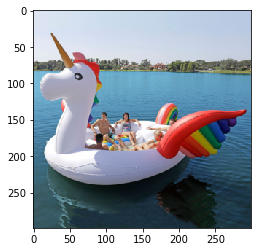

a small bird is sitting on a boat in the water .
a small white and blue bird sitting on a boat .
a small white dog sitting on a boat in the water .
a small bird is on the water with a bird in the background .
a small bird sitting on a boat in the water .
a small white bird sitting on top of a boat .
a small bird sitting on a boat in the water .
a small boat sitting on a boat in the water .
a small bird sitting on a boat in the water .
a small white bird is sitting on a boat .


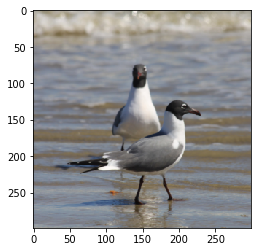

a bird standing on a rock next to a body of water .
a bird standing on a beach next to a body of water .
a bird standing on a rock by the water .
a bird standing on the beach with a bird flying over the water .
a bird is standing on the beach near a body of water .
a bird standing on a rock near a body of water .
a bird is standing on a rock by a body of water .
a bird standing on a beach near the water .
a bird standing on the beach near a body of water .
a bird standing on a rock near a body of water .


In [101]:
for i in range(20):
    img = plt.imread('data/' + str(i) + '.jpg')
    img = imresize(img, (299, 299)).astype('float32') / 255.

    plt.imshow(img)
    plt.show()

    for _ in range(10):
        print(' '.join(generate_caption(img, t=5.)[1:-1]))